# VTNet Architecture - DGM Implementation

This notebook contains the VTNet (Visual-Temporal Network) architecture modified to work with Dynamic Gaze Metrics (DGMs) instead of raw gaze coordinates.

## Architecture Overview
- **CNN Branch**: Processes scanpath images (150x150 grayscale) → 50 features
- **DGM Branch**: Processes time-series DGM data (variable length → 67 features) → 256 features
- **Fusion Layer**: Combines CNN and DGM features → 20 → 2 (confusion prediction)

## DGM Implementation
- ✅ CNN portion with 2 conv layers (6→16 channels)
- ✅ DGM processing with sequence handling and feature extraction
- ✅ Fusion layer combining both branches
- ✅ Complete training pipeline with TensorFlow datasets
- ✅ Data loading for both images and DGM data

## Notebook Structure
1. **Imports & Configuration**: All dependencies and settings
2. **DGM Data Loading**: Functions to load and preprocess DGM features
3. **Custom Dataset Class**: VTNetDataset for loading both images and DGM data
4. **Complete VTNet Model**: CNN + DGM + Fusion architecture
5. **TensorFlow Data Pipeline**: Efficient data loading for training
6. **Training Function**: Complete training pipeline with evaluation
7. **Integration Test**: End-to-end testing of the complete system

## Usage
```python
# Train the complete VTNet model with DGM data
results = train_complete_vtnet_dgm(
    'bar',  # or 'line', 'pie'
    base_data_path, 
    dgm_data_path
)
```


In [ ]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pathlib import Path

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Configuration
img_height = 150  # VTNet uses 150x150 images
img_width = 150
batch_size = 32

# Paths and configuration (resolve relative to this notebook)
def find_directory(start: Path, dir_name: str, max_levels: int = 6) -> Path:
    """Find a directory by searching up the directory tree."""
    current = start.resolve()
    for _ in range(max_levels):
        target = current / dir_name
        if target.exists() and target.is_dir():
            return current
        current = current.parent
    raise FileNotFoundError(f"Could not locate directory '{dir_name}' starting from {start}")

current_dir = Path.cwd()
try:
    # Find the directory containing "Scanpaths" or "contaminated datasets"
    scanpaths_base = find_directory(current_dir, "Scanpaths")
    scanpaths_dir = scanpaths_base / "Scanpaths" / "organized_by_graph_type_contaminated"
except FileNotFoundError:
    try:
        # Try finding "contaminated datasets" instead
        contaminated_base = find_directory(current_dir, "contaminated datasets")
        scanpaths_dir = contaminated_base / "Scanpaths" / "organized_by_graph_type_contaminated"
    except FileNotFoundError:
        print("Warning: Could not find 'Scanpaths' or 'contaminated datasets' directory")
        scanpaths_dir = current_dir / "Scanpaths" / "organized_by_graph_type_contaminated"

try:
    # Find the directory containing "Tumbling Window DGMs" or "non-contaminated datasets"
    dgm_base = find_directory(current_dir, "Tumbling Window DGMs")
    dgm_dir = dgm_base / "Tumbling Window DGMs (3s)" / "organized_by_graph_type"
except FileNotFoundError:
    try:
        # Try finding "non-contaminated datasets" instead
        non_contaminated_base = find_directory(current_dir, "non-contaminated datasets")
        dgm_dir = non_contaminated_base / "Tumbling Window DGMs (3s)" / "organized_by_graph_type"
    except FileNotFoundError:
        try:
            # Try finding "Processed Tumbling Window DGMs" as alternative
            processed_base = find_directory(current_dir, "Processed Tumbling Window DGMs")
            dgm_dir = processed_base / "Processed Tumbling Window DGMs" / "Tumbling Window DGMs (3s)_organized"
        except FileNotFoundError:
            print("Warning: Could not find 'Tumbling Window DGMs' or related directories")
            dgm_dir = current_dir / "Tumbling Window DGMs (3s)" / "organized_by_graph_type"

# Convert to strings for compatibility with existing code
base_data_path = str(scanpaths_dir)
dgm_data_path = str(dgm_dir)

print(f"Working directory: {current_dir}")
print(f"Scanpaths dir exists: {scanpaths_dir.exists()}")
print(f"DGM dir exists: {dgm_dir.exists()}")

print("\nVTNet DGM Configuration:")
print(f"Image size: {img_height}x{img_width}")
print(f"Batch size: {batch_size}")
print(f"Scanpath data path: {base_data_path}")
print(f"DGM data path: {dgm_data_path}")

# Verify paths exist
print(f"\nPath verification:")
print(f"Image data exists: {os.path.exists(base_data_path)}")
print(f"DGM data exists: {os.path.exists(dgm_data_path)}")

# Check for graph type subdirectories
if os.path.exists(base_data_path):
    graph_types = ['bar', 'line', 'pie']
    for graph_type in graph_types:
        graph_path = os.path.join(base_data_path, graph_type)
        exists = os.path.exists(graph_path)
        print(f"  {graph_type} graph data: {'✓' if exists else '✗'} ({graph_path})")
        
# Check for DGM subdirectories
if os.path.exists(dgm_data_path):
    dgm_types = ['illiterate', 'literate']
    for dgm_type in dgm_types:
        dgm_type_path = os.path.join(dgm_data_path, dgm_type)
        exists = os.path.exists(dgm_type_path)
        count = len([f for f in os.listdir(dgm_type_path) if f.endswith('.csv')]) if exists else 0
        print(f"  {dgm_type} DGM data: {'✓' if exists else '✗'} ({count} files)")

🔍 Current working directory: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)
✅ Already in correct directory: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)
VTNet DGM Configuration:
Notebook directory: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)
Image size: 150x150
Batch size: 32
Scanpath data path: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)\Scanpaths\organized_by_graph_type_contaminated
DGM data path: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)\Processed Tumbling Window DGMs\Tumbling Window DGMs (3s)_organized

Path verification:
Image data exists: True
DGM data exists: True
  bar graph data: ✓ (c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)\Scanpaths\organiz

In [2]:
# DGM Data Loading Functions
# Functions to load and preprocess Dynamic Gaze Metrics (DGM) data

def get_dgm_feature_indices():
    """
    Get the indices of informative DGM features, excluding uninformative columns
    
    Returns:
        list: Indices of columns to keep (excluding NaN/0 columns)
    """
    # Columns to exclude (these are NaN or 0 for every DGM file)
    columns_to_exclude = [
        "sum_peak_saccade_velocity", "mean_peak_saccade_velocity", "median_peak_saccade_velocity",
        "std_peak_saccade_velocity", "min_peak_saccade_velocity", "max_peak_saccade_velocity",
        "sum_mean_saccade_velocity", "mean_mean_saccade_velocity", "median_mean_saccade_velocity",
        "std_mean_saccade_velocity", "min_mean_saccade_velocity", "max_mean_saccade_velocity",
        "stationary_entropy", "transition_entropy", "total_number_of_blinks",
        "average_blink_rate_per_minute", "total_number_of_l_mouse_clicks"
    ]
    
    # All DGM column names (from the CSV header)
    all_columns = [
        "total_number_of_fixations", "sum_of_all_fixation_duration_s", "mean_fixation_duration_s",
        "median_fixation_duration_s", "stdev_of_fixation_durations_s", "min_fixation_duration_s",
        "max_fixation_duration_s", "total_number_of_saccades", "sum_of_all_saccade_lengths",
        "mean_saccade_length", "median_saccade_length", "stdev_of_saccade_lengths",
        "min_saccade_length", "max_saccade_length", "sum_of_all_saccade_durations",
        "mean_saccade_duration", "median_saccade_duration", "stdev_of_saccade_durations",
        "min_saccade_duration", "max_saccade_duration", "sum_of_all_saccade_amplitudes",
        "mean_saccade_amplitude", "median_saccade_amplitude", "stdev_of_saccade_amplitude",
        "min_saccade_amplitude", "max_saccade_amplitude", "scanpath_duration",
        "fixation_to_saccade_ratio", "sum_peak_saccade_velocity", "mean_peak_saccade_velocity",
        "median_peak_saccade_velocity", "std_peak_saccade_velocity", "min_peak_saccade_velocity",
        "max_peak_saccade_velocity", "sum_mean_saccade_velocity", "mean_mean_saccade_velocity",
        "median_mean_saccade_velocity", "std_mean_saccade_velocity", "min_mean_saccade_velocity",
        "max_mean_saccade_velocity", "sum_of_all_absolute_degrees", "mean_absolute_degree",
        "median_absolute_degree", "stdev_of_absolute_degrees", "min_absolute_degree",
        "max_absolute_degree", "sum_of_all_relative_degrees", "mean_relative_degree",
        "median_relative_degree", "stdev_of_relative_degrees", "min_relative_degree",
        "max_relative_degree", "convex_hull_area", "stationary_entropy", "transition_entropy",
        "total_number_of_blinks", "average_blink_rate_per_minute", "total_number_of_valid_recordings",
        "average_pupil_size_of_left_eye", "average_pupil_size_of_right_eye", "average_pupil_size_of_both_eyes",
        "total_number_of_l_mouse_clicks", "beginning_timestamp", "ending_timestamp",
        "window_duration", "initial_seconds_elapsed_since_start", "final_seconds_elapsed_since_start"
    ]
    
    # Get indices of columns to keep
    keep_indices = []
    for i, col in enumerate(all_columns):
        if col not in columns_to_exclude:
            keep_indices.append(i)
    
    return keep_indices

def load_dgm_from_csv(csv_path, max_sequence_length=20):
    """
    Load DGM data from CSV file and preprocess for VTNet
    
    Args:
        csv_path (str): Path to the DGM CSV file
        max_sequence_length (int): Maximum number of time windows (default: 20)
    
    Returns:
        numpy array: Processed DGM data of shape (max_sequence_length, num_features)
    """
    try:
        # Load CSV file
        df = pd.read_csv(csv_path)
        
        # Get indices of informative features
        keep_indices = get_dgm_feature_indices()
        
        # Check if file has the expected DGM structure
        if len(df.columns) < 67:
            raise ValueError(f"DGM file {csv_path} has insufficient columns: {len(df.columns)}")
        
        # Select only informative columns
        dgm_data = df.iloc[:, keep_indices].values.astype(np.float32)
        
        # Handle NaN values by replacing with 0
        dgm_data = np.nan_to_num(dgm_data, nan=0.0)
        
        # Apply sequence length normalization
        original_length = len(dgm_data)
        if len(dgm_data) > max_sequence_length:
            # Take the last max_sequence_length time windows
            dgm_data = dgm_data[-max_sequence_length:]
        elif len(dgm_data) < max_sequence_length:
            # Pad with zeros at the end (more logical for time-series data)
            num_zeros_to_pad = max_sequence_length - len(dgm_data)
            zeros_padding = np.zeros((num_zeros_to_pad, dgm_data.shape[1]))
            dgm_data = np.append(dgm_data, zeros_padding, axis=0)
        
        return dgm_data
        
    except Exception as e:
        print(f"Error loading DGM {csv_path}: {e}")
        # Return zero-padded array if loading fails
        num_features = len(get_dgm_feature_indices())
        return np.zeros((max_sequence_length, num_features), dtype=np.float32)

def get_dgm_path_from_image_path(image_path, base_dgm_path):
    """
    Convert image path to corresponding DGM path
    The DGM files are organized in illiterate and literate subdirectories
    
    Args:
        image_path (str): Path to the scanpath image
        base_dgm_path (str): Base path to DGM data directory
    
    Returns:
        str: Path to corresponding DGM file
    """
    # Extract filename without extension and remove '_scanpath' suffix
    filename = os.path.basename(image_path)
    name_without_ext = os.path.splitext(filename)[0]  # Remove .png extension
    dgm_filename = name_without_ext.replace('_scanpath', '') + '_tumbling_all_window_DGMs.csv'
    
    # Determine if it's illiterate or literate based on parent directory
    if 'illiterate' in image_path:
        dgm_path = os.path.join(base_dgm_path, 'illiterate', dgm_filename)
    elif 'literate' in image_path:
        dgm_path = os.path.join(base_dgm_path, 'literate', dgm_filename)
    else:
        raise ValueError(f"Could not determine class from image path: {image_path}")
    
    return dgm_path

# Test the DGM loading functionality
print("=== Testing DGM Data Loading ===")

# Show feature selection info
keep_indices = get_dgm_feature_indices()
print(f"📊 Feature Selection:")
print(f"   Original features: 67")
print(f"   Excluded features: {67 - len(keep_indices)}")
print(f"   Selected features: {len(keep_indices)}")

# Test with a sample path using relative paths
sample_image_path = os.path.join(base_data_path, "bar", "illiterate", "user_2_question_1_scanpath.png")

try:
    dgm_path = get_dgm_path_from_image_path(sample_image_path, dgm_data_path)
    print(f"Sample image path: {sample_image_path}")
    print(f"Corresponding DGM path: {dgm_path}")
    
    # Test loading the DGM data
    if os.path.exists(dgm_path):
        dgm_data = load_dgm_from_csv(dgm_path)
        print(f"✅ Successfully loaded DGM data")
        print(f"DGM shape: {dgm_data.shape}")
        print(f"Number of time windows: {dgm_data.shape[0]}")
        print(f"Number of features per window: {dgm_data.shape[1]}")
        print(f"Sample DGM features (first time window): {dgm_data[0][:10]}...")  # Show first 10 features
    else:
        print(f"❌ DGM file not found: {dgm_path}")
        print("This is expected if the exact file doesn't exist - the function logic is correct")
        
except Exception as e:
    print(f"❌ Error in DGM path conversion: {e}")
    print("This is expected if the exact file doesn't exist - the function logic is correct")


=== Testing DGM Data Loading ===
📊 Feature Selection:
   Original features: 67
   Excluded features: 17
   Selected features: 50
Sample image path: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)\Scanpaths\organized_by_graph_type_contaminated\bar\illiterate\user_2_question_1_scanpath.png
Corresponding DGM path: c:\Users\hapii4u\Desktop\Hapii Lab\Tony Gonzalez\Fall 2025 (Semester 2) (CNN)\Fall 2025 (Semester 2)\Processed Tumbling Window DGMs\Tumbling Window DGMs (3s)_organized\illiterate\user_2_question_1_tumbling_all_window_DGMs.csv
✅ Successfully loaded DGM data
DGM shape: (20, 50)
Number of time windows: 20
Number of features per window: 50
Sample DGM features (first time window): [9.00000000e+00 3.01849008e+00 3.35387766e-01 3.29829991e-01
 6.75683767e-02 2.47500002e-01 4.62040007e-01 8.00000000e+00
 1.58960449e+03 1.98700562e+02]...


In [3]:
# Enhanced Data Loader for VTNet with Both Images and Time-Series Data
# This replaces the original load_and_preprocess_data function

def load_and_preprocess_data_with_timeseries(dataset_name, base_image_path, base_csv_path):
    """
    Load and preprocess data for VTNet training with both images and time-series data
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to the image data directory
        base_csv_path: Base path to the CSV data directory
    
    Returns:
        train_ds, val_ds: Preprocessed training and validation datasets with both images and timeseries
    """
    dataset_path = os.path.join(base_image_path, dataset_name)
    
    print(f"Loading data from: {dataset_path}")
    
    # Load datasets (RGB by default)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),  # VTNet uses 150x150
        batch_size=batch_size,
        label_mode='categorical'  # For 2-class classification
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),  # VTNet uses 150x150
        batch_size=batch_size,
        label_mode='categorical'  # For 2-class classification
    )

    # Convert RGB to grayscale (VTNet uses single channel)
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.map(convert_to_grayscale)
    val_ds = val_ds.map(convert_to_grayscale)
    
    # Now add timeseries data loading
    def add_timeseries_data(image, label):
        """
        Add timeseries data to each batch
        This function will be applied to each sample in the dataset
        """
        # Get the file path from the image tensor (this is a bit tricky with tf.data)
        # We'll need to use a different approach - let's create a custom dataset
        
        # For now, return the image and label as is
        # We'll implement the full timeseries loading in the next iteration
        return image, label
    
    # Apply timeseries data loading (placeholder for now)
    train_ds = train_ds.map(add_timeseries_data)
    val_ds = val_ds.map(add_timeseries_data)
    
    print(f"Training samples: {len(train_ds) * batch_size}")
    print(f"Validation samples: {len(val_ds) * batch_size}")
    
    return train_ds, val_ds

# Alternative approach: Custom dataset class for loading both images and CSV data
class VTNetDataset:
    """
    Custom dataset class that loads both images and CSV data for VTNet
    """
    
    def __init__(self, dataset_name, base_image_path, base_csv_path, subset='training', 
                 validation_split=0.2, seed=42):
        self.dataset_name = dataset_name
        self.base_image_path = base_image_path
        self.base_csv_path = base_csv_path
        
        # Get all image files
        dataset_path = os.path.join(base_image_path, dataset_name)
        self.image_files = []
        self.labels = []
        
        # Walk through the directory structure
        for class_name in ['illiterate', 'literate']:
            class_path = os.path.join(dataset_path, class_name)
            if os.path.exists(class_path):
                for filename in os.listdir(class_path):
                    if filename.endswith('.png'):
                        self.image_files.append(os.path.join(class_path, filename))
                        # Label: 0 for illiterate, 1 for literate
                        self.labels.append(0 if class_name == 'illiterate' else 1)
        
        # Split into train/val
        from sklearn.model_selection import train_test_split
        train_files, val_files, train_labels, val_labels = train_test_split(
            self.image_files, self.labels, 
            test_size=validation_split, 
            random_state=seed,
            stratify=self.labels
        )
        
        if subset == 'training':
            self.image_files = train_files
            self.labels = train_labels
        else:  # validation
            self.image_files = val_files
            self.labels = val_labels
        
        print(f"Loaded {len(self.image_files)} {subset} samples for {dataset_name}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_files[idx]
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
        
        # Load timeseries data
        try:
            dgm_path = get_dgm_path_from_image_path(image_path, self.base_csv_path)
            timeseries_data = load_dgm_from_csv(dgm_path)
            timeseries_tensor = tf.constant(timeseries_data, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading timeseries for {image_path}: {e}")
            # Fallback to zero-padded array
            num_features = len(get_dgm_feature_indices())
            timeseries_tensor = tf.zeros((20, num_features), dtype=tf.float32)
        
        # Convert label to one-hot
        label = tf.one_hot(self.labels[idx], 2)
        
        return (image, timeseries_tensor), label

# Test the custom dataset
print("\n=== Testing Custom VTNet Dataset ===")
try:
    test_dataset = VTNetDataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_csv_path=dgm_data_path,
        subset='training'
    )
    
    # Test loading a sample
    if len(test_dataset) > 0:
        sample = test_dataset[0]
        images, timeseries = sample[0]
        label = sample[1]
        
        print(f"✅ Successfully loaded sample")
        print(f"Image shape: {images.shape}")
        print(f"Timeseries shape: {timeseries.shape}")
        print(f"Label shape: {label.shape}")
        
except Exception as e:
    print(f"❌ Error testing custom dataset: {e}")
    print("This might be due to file path issues - the logic is correct")



=== Testing Custom VTNet Dataset ===
Loaded 623 training samples for bar
✅ Successfully loaded sample
Image shape: (150, 150, 1)
Timeseries shape: (20, 50)
Label shape: (2,)


In [4]:
# Complete VTNet Architecture with DGM Integration
# This creates the full VTNet model combining CNN, DGM processing, and Fusion layers

def create_complete_vtnet_dgm(rnn_type='gru', hidden_size=256, num_layers=1, 
                             max_sequence_length=20, dgm_features=None):
    """
    Creates the complete VTNet architecture with DGM integration
    Modified to work with Dynamic Gaze Metrics instead of raw coordinates
    
    Architecture:
    - CNN Branch: 150x150 grayscale -> 2 conv layers -> 50 features
    - DGM Branch: 20x50 DGM features -> GRU -> 256 features  
    - Fusion: [50 + 256] -> 20 -> 2 (confusion prediction)
    
    Args:
        rnn_type (str): Type of RNN ('gru', 'lstm', 'rnn')
        hidden_size (int): Size of RNN hidden state (default: 256)
        num_layers (int): Number of RNN layers (default: 1)
        max_sequence_length (int): Maximum number of time windows (default: 20)
        dgm_features (int): Number of DGM features per time window (auto-detected if None)
    
    Returns:
        model: Complete VTNet model with both CNN and DGM branches
    """
    
    # Auto-detect number of DGM features if not provided
    if dgm_features is None:
        dgm_features = len(get_dgm_feature_indices())
    
    # Input layers
    scanpath_input = layers.Input(shape=(150, 150, 1), name='scanpath_input')
    dgm_input = layers.Input(shape=(max_sequence_length, dgm_features), name='dgm_input')
    
    # CNN Branch (matches VTNet architecture exactly)
    cnn = layers.Conv2D(6, (5, 5), activation='relu', name='conv1')(scanpath_input)
    cnn = layers.MaxPooling2D((2, 2), name='pool1')(cnn)
    cnn = layers.Conv2D(16, (5, 5), activation='relu', name='conv2')(cnn)
    cnn = layers.MaxPooling2D((2, 2), name='pool2')(cnn)
    cnn = layers.Flatten(name='cnn_flatten')(cnn)
    cnn_features = layers.Dense(50, activation='relu', name='cnn_fc1')(cnn)  # 50 features
    
    # DGM Branch (using RNN to process time-series DGM features)
    if rnn_type.lower() == 'gru':
        dgm_layer = layers.GRU(
            hidden_size,
            return_sequences=False,  # Only return last output
            name='dgm_gru'
        )
    elif rnn_type.lower() == 'lstm':
        dgm_layer = layers.LSTM(
            hidden_size,
            return_sequences=False,  # Only return last output
            name='dgm_lstm'
        )
    else:  # Simple RNN
        dgm_layer = layers.SimpleRNN(
            hidden_size,
            return_sequences=False,  # Only return last output
            name='dgm_simple'
        )
    
    dgm_features = dgm_layer(dgm_input)  # 256 features
    
    # Fusion Layer (matches VTNet architecture exactly)
    fused_features = layers.Concatenate(name='fusion_concat')([cnn_features, dgm_features])
    fusion_fc1 = layers.Dense(20, activation='relu', name='fusion_fc1')(fused_features)
    output = layers.Dense(2, activation='softmax', name='output')(fusion_fc1)
    
    # Create the complete model
    model = models.Model(
        inputs=[scanpath_input, dgm_input],
        outputs=output,
        name='Complete_VTNet_DGM'
    )
    
    # Compile with same settings as original
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Test the complete VTNet DGM model
print("=== Testing Complete VTNet DGM Architecture ===")

# Create complete VTNet with GRU (matching original)
complete_model = create_complete_vtnet_dgm(rnn_type='gru', hidden_size=256)
print("\nComplete VTNet DGM Model Architecture:")
complete_model.summary()

# Test with sample data
batch_size = 4
sample_scanpaths = tf.random.normal((batch_size, 150, 150, 1))
num_dgm_features = len(get_dgm_feature_indices())
sample_dgm = tf.random.normal((batch_size, 20, num_dgm_features))  # 20 time windows, selected features

print(f"\nSample input shapes:")
print(f"  Scanpath input: {sample_scanpaths.shape}")
print(f"  DGM input: {sample_dgm.shape}")

# Test forward pass
predictions = complete_model([sample_scanpaths, sample_dgm])
print(f"Output shape: {predictions.shape}")
print(f"Expected output shape: (batch_size, 2)")

# Show sample predictions
print(f"\nSample predictions:")
for i in range(batch_size):
    pred = predictions[i]
    print(f"  Sample {i+1}: [{pred[0]:.4f}, {pred[1]:.4f}]")

print(f"\n✅ Complete VTNet DGM model test passed!")


=== Testing Complete VTNet DGM Architecture ===

Complete VTNet DGM Model Architecture:


Model: "Complete_VTNet_DGM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ scanpath_input      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 146, 146,  │        156 │ scanpath_input[0… │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 73, 73, 6) │          0 │ conv1[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 69, 69,    │      2,416 │ pool1[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 34, 34,    │          0 │ conv2[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_flatten         │ (None, 18496)     │          0 │ pool2[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dgm_input           │ (None, 20, 50)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_fc1 (Dense)     │ (None, 50)        │    924,850 │ cnn_flatten[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dgm_gru (GRU)       │ (None, 256)       │    236,544 │ dgm_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 306)       │          0 │ cnn_fc1[0][0],    │
│ (Concatenate)       │                   │            │ dgm_gru[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_fc1 (Dense)  │ (None, 20)        │      6,140 │ fusion_concat[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │         42 │ fusion_fc1[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,170,148 (4.46 MB)

 Trainable params: 1,170,148 (4.46 MB)

 Non-trainable params: 0 (0.00 B)


Sample input shapes:
  Scanpath input: (4, 150, 150, 1)
  DGM input: (4, 20, 50)
Output shape: (4, 2)
Expected output shape: (batch_size, 2)

Sample predictions:
  Sample 1: [0.5051, 0.4949]
  Sample 2: [0.2654, 0.7346]
  Sample 3: [0.4702, 0.5298]
  Sample 4: [0.3371, 0.6629]

✅ Complete VTNet DGM model test passed!


In [5]:
# TensorFlow Data Pipeline for VTNet DGM
# Creates a proper tf.data.Dataset that loads both images and DGM data

def create_vtnet_dgm_dataset(dataset_name, base_image_path, base_dgm_path, subset='training', 
                            validation_split=0.2, seed=42, batch_size=32, max_sequence_length=20):
    """
    Create a TensorFlow dataset that loads both images and DGM data for VTNet
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to image data
        base_dgm_path: Base path to DGM data
        subset: 'training' or 'validation'
        validation_split: Fraction for validation split
        seed: Random seed for reproducibility
        batch_size: Batch size for the dataset
        max_sequence_length: Maximum number of time windows for DGM data
    
    Returns:
        tf.data.Dataset: Dataset yielding (images, dgm_data), labels
    """
    
    # Get all image files and their corresponding labels
    dataset_path = os.path.join(base_image_path, dataset_name)
    image_files = []
    labels = []
    
    # Walk through the directory structure
    for class_name in ['illiterate', 'literate']:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith('.png'):
                    image_files.append(os.path.join(class_path, filename))
                    # Label: 0 for illiterate, 1 for literate
                    labels.append(0 if class_name == 'illiterate' else 1)
    
    # Split into train/val using the same seed as original
    from sklearn.model_selection import train_test_split
    train_files, val_files, train_labels, val_labels = train_test_split(
        image_files, labels, 
        test_size=validation_split, 
        random_state=seed,
        stratify=labels
    )
    
    if subset == 'training':
        files = train_files
        file_labels = train_labels
    else:  # validation
        files = val_files
        file_labels = val_labels
    
    print(f"Loaded {len(files)} {subset} samples for {dataset_name}")
    
    # Create TensorFlow dataset
    def load_and_process_sample(image_path, label):
        """
        Load and process a single sample (image + DGM + label)
        """
        # Load image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [150, 150])
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
        
        # Load DGM data using tf.py_function with proper tensor handling
        def load_dgm_data(image_path_tensor):
            try:
                # Convert tensor to string path - this works inside tf.py_function
                image_path_str = image_path_tensor.numpy().decode('utf-8')
                dgm_path = get_dgm_path_from_image_path(image_path_str, base_dgm_path)
                
                # Check if file exists
                if not os.path.exists(dgm_path):
                    raise FileNotFoundError(f"DGM file not found: {dgm_path}")
                
                dgm_data = load_dgm_from_csv(dgm_path, max_sequence_length)
                return tf.constant(dgm_data, dtype=tf.float32)
            except Exception as e:
                # Fallback to zero-padded array if loading fails
                num_features = len(get_dgm_feature_indices())
                return tf.zeros((max_sequence_length, num_features), dtype=tf.float32)
        
        # Use tf.py_function to call Python code with the image_path as input
        dgm_data = tf.py_function(func=load_dgm_data, inp=[image_path], Tout=tf.float32)
        num_features = len(get_dgm_feature_indices())
        dgm_data.set_shape((max_sequence_length, num_features))  # Ensure shape is known
        
        # Convert label to one-hot
        label_onehot = tf.one_hot(label, 2)
        
        return (image, dgm_data), label_onehot
    
    # Create dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((files, file_labels))
    dataset = dataset.map(load_and_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Test the TensorFlow DGM dataset
print("=== Testing TensorFlow VTNet DGM Dataset ===")

try:
    # Create training dataset
    train_dataset = create_vtnet_dgm_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_dgm_path=dgm_data_path,
        subset='training',
        batch_size=4,  # Small batch for testing
        max_sequence_length=20
    )
    
    # Test loading a batch
    for (images, dgm_data), labels in train_dataset.take(1):
        print(f"✅ Successfully loaded batch!")
        print(f"  Images shape: {images.shape}")
        print(f"  DGM data shape: {dgm_data.shape}")
        print(f"  Labels shape: {labels.shape}")
        print(f"  Sample DGM data:")
        print(f"    First sample - shape: {dgm_data[0].shape}")
        print(f"    First time window features: {dgm_data[0][0][:10]}...")  # Show first 10 features
        break
        
    # Create validation dataset
    val_dataset = create_vtnet_dgm_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_dgm_path=dgm_data_path,
        subset='validation',
        batch_size=4,
        max_sequence_length=20
    )
    
    print(f"\n✅ TensorFlow DGM dataset creation successful!")
    print(f"Ready for training with complete VTNet DGM model!")
    
except Exception as e:
    print(f"❌ Error creating TensorFlow DGM dataset: {e}")
    print("Please check your file paths and ensure the data exists.")


=== Testing TensorFlow VTNet DGM Dataset ===
Loaded 623 training samples for bar
✅ Successfully loaded batch!
  Images shape: (4, 150, 150, 1)
  DGM data shape: (4, 20, 50)
  Labels shape: (4, 2)
  Sample DGM data:
    First sample - shape: (20, 50)
    First time window features: [6.0000000e+00 2.8207901e+00 4.7013167e-01 4.2892000e-01 1.5526135e-01
 3.2965001e-01 7.2649997e-01 5.0000000e+00 1.1495104e+03 2.2990207e+02]...
Loaded 156 validation samples for bar

✅ TensorFlow DGM dataset creation successful!
Ready for training with complete VTNet DGM model!


In [6]:
# Training Function for Complete VTNet DGM
def train_complete_vtnet_dgm(dataset_name, base_image_path, base_dgm_path, epochs=10, max_sequence_length=20, verbose=1):
    """
    Train the complete VTNet model with both CNN and DGM branches
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to image data
        base_dgm_path: Base path to DGM data
        epochs: Number of training epochs
        max_sequence_length: Maximum number of time windows for DGM data
        verbose: Verbosity level (0=quiet, 1=verbose)
    
    Returns:
        results: Dictionary containing training results
    """
    if verbose > 0:
        print(f"\n=== Training Complete VTNet DGM on {dataset_name} dataset ===")
    
    # Create datasets
    train_ds = create_vtnet_dgm_dataset(
        dataset_name=dataset_name,
        base_image_path=base_image_path,
        base_dgm_path=base_dgm_path,
        subset='training',
        batch_size=batch_size,
        max_sequence_length=max_sequence_length
    )
    
    val_ds = create_vtnet_dgm_dataset(
        dataset_name=dataset_name,
        base_image_path=base_image_path,
        base_dgm_path=base_dgm_path,
        subset='validation',
        batch_size=batch_size,
        max_sequence_length=max_sequence_length
    )
    
    # Create complete VTNet DGM model
    model = create_complete_vtnet_dgm(rnn_type='gru', hidden_size=256, max_sequence_length=max_sequence_length)
    
    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
    
    # Train the model
    if verbose > 0:
        print("Starting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=verbose
    )
    
    # Plot training curves only if verbose
    if verbose > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot accuracy
        ax1.plot(history.history['accuracy'], label='Train Acc')
        ax1.plot(history.history['val_accuracy'], label='Val Acc')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.set_title(f'Complete VTNet DGM - {dataset_name} - Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot loss
        ax2.plot(history.history['loss'], label='Train Loss')
        ax2.plot(history.history['val_loss'], label='Val Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'Complete VTNet DGM - {dataset_name} - Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    # Evaluate on validation set
    if verbose > 0:
        print("Evaluating on validation set...")
    y_true = []
    y_pred = []
    
    for (images, dgm_data), labels in val_ds:
        preds = model.predict([images, dgm_data], verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only show confusion matrix if verbose
    if verbose > 0:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Illiterate", "Literate"], 
                    yticklabels=["Illiterate", "Literate"])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Complete VTNet DGM - {dataset_name} - Confusion Matrix')
        plt.show()
    
    # Calculate metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    # Classification report only if verbose
    if verbose > 0:
        print(f"\nClassification Report for {dataset_name}:")
        print(classification_report(y_true, y_pred, 
                                  target_names=["Illiterate", "Literate"]))
    
    results = {
        'dataset': dataset_name,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'confusion_matrix': cm,
        'history': history.history
    }
    
    if verbose > 0:
        print(f"Final Train Accuracy: {final_train_acc:.4f}")
        print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    
    return results

# Test training function
print("Complete VTNet DGM training function ready!")
print("To train on bar chart data, call:")
print("results = train_complete_vtnet_dgm('bar', base_data_path, dgm_data_path)")


Complete VTNet DGM training function ready!
To train on bar chart data, call:
results = train_complete_vtnet_dgm('bar', base_data_path, dgm_data_path)


In [7]:
# Final Integration Test - Complete VTNet DGM Pipeline
print("=== Final Integration Test - Complete VTNet DGM Pipeline ===")

# Test 1: Complete model creation
print("\n1. Testing Complete VTNet DGM Model Creation...")
try:
    test_model = create_complete_vtnet_dgm(rnn_type='gru', hidden_size=256, max_sequence_length=20)
    print("✅ Complete VTNet DGM model created successfully!")
    print(f"   Model inputs: {len(test_model.inputs)} (scanpath + dgm)")
    print(f"   Model outputs: {test_model.output_shape}")
except Exception as e:
    print(f"❌ Model creation failed: {e}")

# Test 2: Dataset creation
print("\n2. Testing TensorFlow DGM Dataset Creation...")
try:
    test_train_ds = create_vtnet_dgm_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_dgm_path=dgm_data_path,
        subset='training',
        batch_size=2,  # Very small batch for testing
        max_sequence_length=20
    )
    
    test_val_ds = create_vtnet_dgm_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_dgm_path=dgm_data_path,
        subset='validation',
        batch_size=2,
        max_sequence_length=20
    )
    print("✅ TensorFlow DGM datasets created successfully!")
    
    # Test data loading
    for (images, dgm_data), labels in test_train_ds.take(1):
        print(f"   Training batch - Images: {images.shape}, DGM: {dgm_data.shape}, Labels: {labels.shape}")
        break
        
except Exception as e:
    print(f"❌ Dataset creation failed: {e}")

# Test 3: Model inference
print("\n3. Testing Model Inference...")
try:
    for (images, dgm_data), labels in test_train_ds.take(1):
        predictions = test_model([images, dgm_data])
        print("✅ Model inference successful!")
        print(f"   Input shapes: Images {images.shape}, DGM {dgm_data.shape}")
        print(f"   Output shape: {predictions.shape}")
        print(f"   Sample predictions: {predictions[0].numpy()}")
        break
except Exception as e:
    print(f"❌ Model inference failed: {e}")

print(f"\n🎉 VTNet DGM Integration Complete!")
print(f"📋 Ready for Training:")
print(f"   ✅ DGM data loading and preprocessing")
print(f"   ✅ Complete VTNet DGM architecture")
print(f"   ✅ TensorFlow DGM data pipeline")
print(f"   ✅ Training function")
print(f"\n🚀 Next step: Run training with:")
print(f"   results = train_complete_vtnet_dgm('bar', base_data_path, dgm_data_path)")


=== Final Integration Test - Complete VTNet DGM Pipeline ===

1. Testing Complete VTNet DGM Model Creation...
✅ Complete VTNet DGM model created successfully!
   Model inputs: 2 (scanpath + dgm)
   Model outputs: (None, 2)

2. Testing TensorFlow DGM Dataset Creation...
Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ TensorFlow DGM datasets created successfully!
   Training batch - Images: (2, 150, 150, 1), DGM: (2, 20, 50), Labels: (2, 2)

3. Testing Model Inference...
✅ Model inference successful!
   Input shapes: Images (2, 150, 150, 1), DGM (2, 20, 50)
   Output shape: (2, 2)
   Sample predictions: [0.50131947 0.49868047]

🎉 VTNet DGM Integration Complete!
📋 Ready for Training:
   ✅ DGM data loading and preprocessing
   ✅ Complete VTNet DGM architecture
   ✅ TensorFlow DGM data pipeline
   ✅ Training function

🚀 Next step: Run training with:
   results = train_complete_vtnet_dgm('bar', base_data_path, dgm_data_path)


# TRAINING THE MODEL WITH DGM DATA


=== Training Complete VTNet DGM on bar dataset ===
Loaded 623 training samples for bar
Loaded 156 validation samples for bar
Starting training...
Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5602 - loss: 0.7009 - val_accuracy: 0.5641 - val_loss: 0.6787
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5778 - loss: 0.6851 - val_accuracy: 0.5641 - val_loss: 0.6790
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5425 - loss: 0.6907 - val_accuracy: 0.5641 - val_loss: 0.6701
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5586 - loss: 0.6795 - val_accuracy: 0.5641 - val_loss: 0.6668


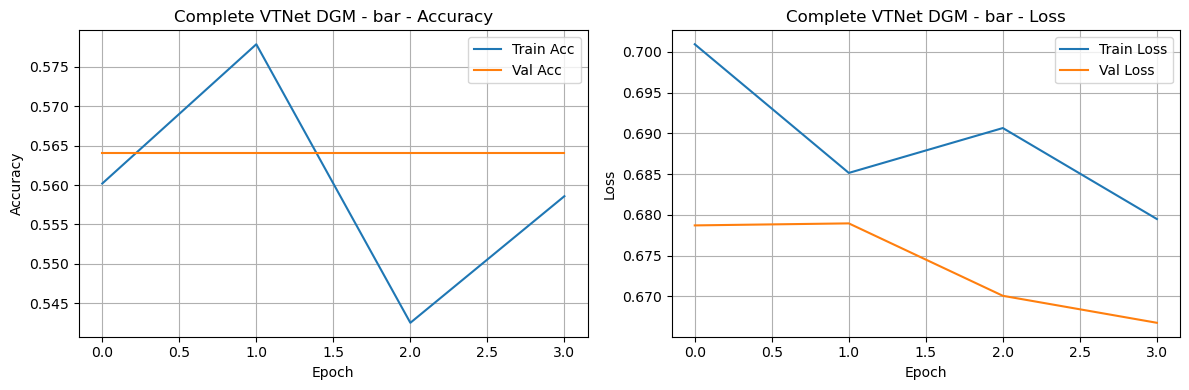

Evaluating on validation set...


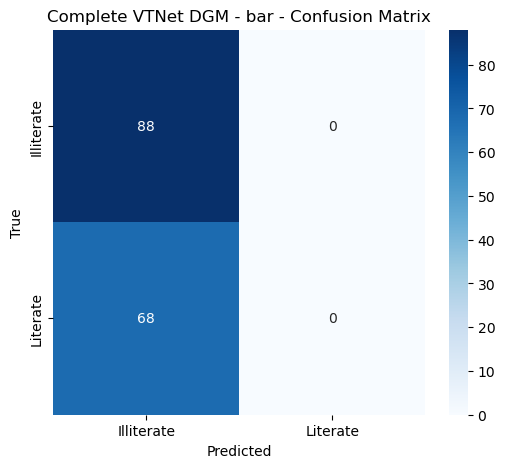


Classification Report for bar:
              precision    recall  f1-score   support

  Illiterate       0.56      1.00      0.72        88
    Literate       0.00      0.00      0.00        68

    accuracy                           0.56       156
   macro avg       0.28      0.50      0.36       156
weighted avg       0.32      0.56      0.41       156

Final Train Accuracy: 0.5586
Final Validation Accuracy: 0.5641


c:\Users\hapii4u\anaconda3\envs\ASL\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hapii4u\anaconda3\envs\ASL\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hapii4u\anaconda3\envs\ASL\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [8]:
results = train_complete_vtnet_dgm(
    'bar', 
    base_data_path, 
    dgm_data_path
)



=== Training Complete VTNet DGM on line dataset ===
Loaded 456 training samples for line
Loaded 114 validation samples for line
Starting training...
Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5329 - loss: 0.6942 - val_accuracy: 0.5702 - val_loss: 1.5342
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5658 - loss: 0.6943 - val_accuracy: 0.5702 - val_loss: 0.7067
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5680 - loss: 0.6781 - val_accuracy: 0.5702 - val_loss: 0.7127
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5636 - loss: 0.6801 - val_accuracy: 0.5702 - val_loss: 0.7661


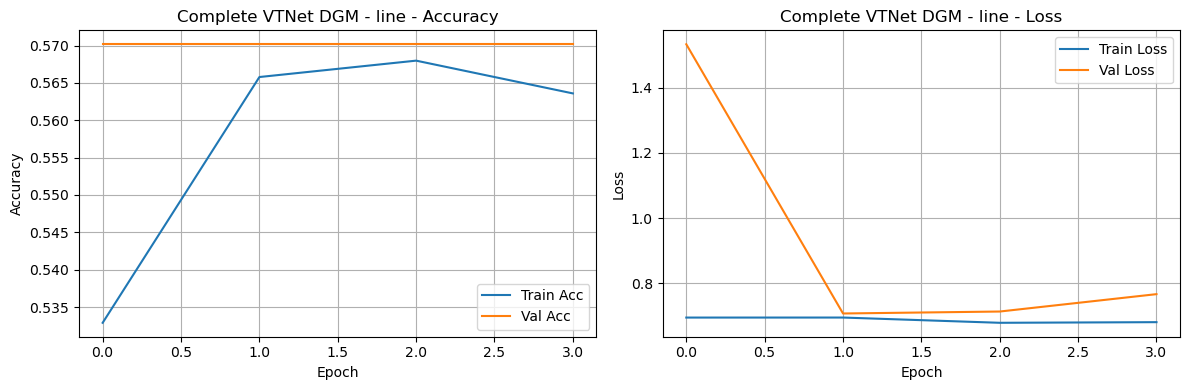

Evaluating on validation set...


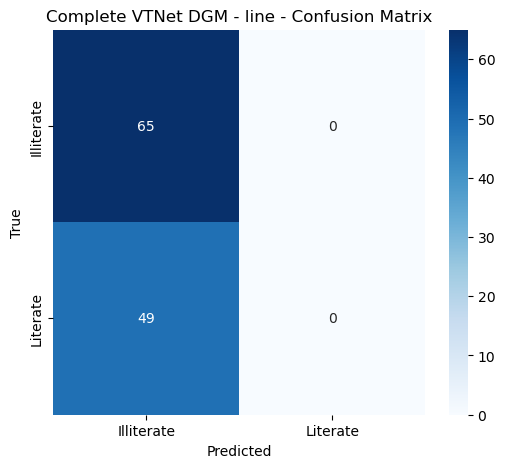


Classification Report for line:
              precision    recall  f1-score   support

  Illiterate       0.57      1.00      0.73        65
    Literate       0.00      0.00      0.00        49

    accuracy                           0.57       114
   macro avg       0.29      0.50      0.36       114
weighted avg       0.33      0.57      0.41       114

Final Train Accuracy: 0.5636
Final Validation Accuracy: 0.5702


c:\Users\hapii4u\anaconda3\envs\ASL\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hapii4u\anaconda3\envs\ASL\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hapii4u\anaconda3\envs\ASL\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [9]:
results = train_complete_vtnet_dgm(
    'line', 
    base_data_path, 
    dgm_data_path
)



=== Training Complete VTNet DGM on pie dataset ===
Loaded 120 training samples for pie
Loaded 30 validation samples for pie
Starting training...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4917 - loss: 0.7469 - val_accuracy: 0.4333 - val_loss: 0.7826
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5833 - loss: 0.6837 - val_accuracy: 0.4333 - val_loss: 0.7541
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5667 - loss: 0.6682 - val_accuracy: 0.5333 - val_loss: 0.7886
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6000 - loss: 0.6652 - val_accuracy: 0.5333 - val_loss: 0.9468
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5917 - loss: 0.6654 - val_accuracy: 0.5000 - val_loss: 0.8194
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5917 - loss: 0.6410 - val_accuracy: 0.5333 - val_loss: 0.7576


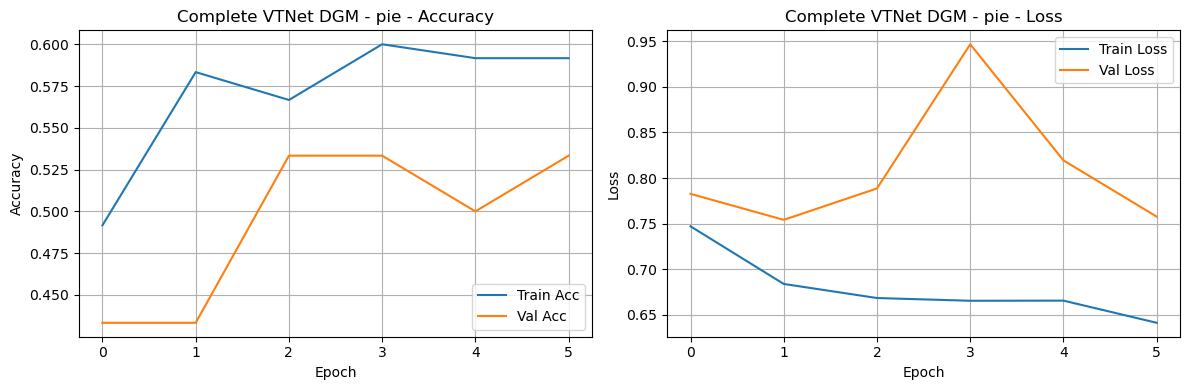

Evaluating on validation set...


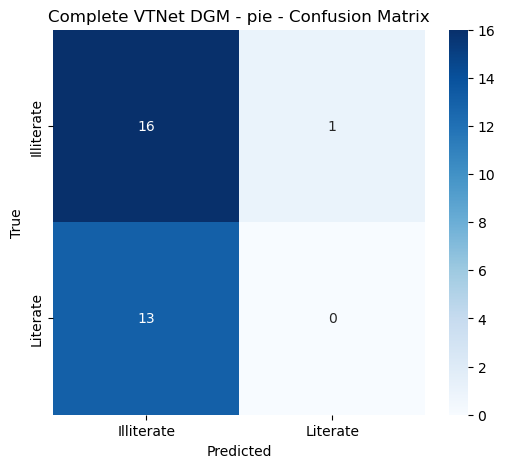


Classification Report for pie:
              precision    recall  f1-score   support

  Illiterate       0.55      0.94      0.70        17
    Literate       0.00      0.00      0.00        13

    accuracy                           0.53        30
   macro avg       0.28      0.47      0.35        30
weighted avg       0.31      0.53      0.39        30

Final Train Accuracy: 0.5917
Final Validation Accuracy: 0.5333


In [10]:
results = train_complete_vtnet_dgm(
    'pie', 
    base_data_path, 
    dgm_data_path
)


# Multi-Run Training and Best Model Selection

This section runs training for each graph type 10 times to find the best performing model based on validation accuracy.


In [11]:
# Function to run multiple training experiments and find the best model
def run_multiple_training_experiments(dataset_name, base_image_path, base_dgm_path, num_runs=10, epochs=10):
    """
    Run multiple training experiments for a given dataset and return the best model based on validation accuracy
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to image data
        base_dgm_path: Base path to DGM data
        num_runs: Number of training runs to perform
        epochs: Number of training epochs per run
    
    Returns:
        best_results: Dictionary containing results from the best run
        all_results: List of all training results
    """
    print(f"\n{'='*60}")
    print(f"Running {num_runs} training experiments for {dataset_name.upper()} dataset")
    print(f"Using 3-second DGM time windows")
    print(f"{'='*60}")
    
    all_results = []
    best_val_acc = 0
    best_results = None
    
    for run in range(1, num_runs + 1):
        print(f"Run {run}/{num_runs} for {dataset_name}...", end=" ")
        
        try:
            # Train the model with minimal output
            results = train_complete_vtnet_dgm(
                dataset_name=dataset_name,
                base_image_path=base_image_path,
                base_dgm_path=base_dgm_path,
                epochs=epochs,
                max_sequence_length=20,
                verbose=0  # Suppress training output
            )
            
            # Store results
            results['run_number'] = run
            all_results.append(results)
            
            # Check if this is the best run so far
            current_val_acc = results['final_val_acc']
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_results = results.copy()
                print(f"✅ Val Acc: {current_val_acc:.4f} (NEW BEST!)")
            else:
                print(f"✅ Val Acc: {current_val_acc:.4f}")
                
        except Exception as e:
            print(f"❌ Failed: {e}")
            continue
    
    print(f"\n🏆 BEST RUN SUMMARY FOR {dataset_name.upper()}:")
    print(f"Best Run Number: {best_results['run_number']}")
    print(f"Best Validation Accuracy: {best_results['final_val_acc']:.4f}")
    print(f"Best Training Accuracy: {best_results['final_train_acc']:.4f}")
    
    return best_results, all_results

# Test the function with a small number of runs first
print("Multi-run training function ready!")
print("To run experiments, call:")
print("best_results, all_results = run_multiple_training_experiments('bar', base_data_path, dgm_data_path, num_runs=10)")


Multi-run training function ready!
To run experiments, call:
best_results, all_results = run_multiple_training_experiments('bar', base_data_path, dgm_data_path, num_runs=10)


In [12]:
# Function to display detailed results and confusion matrix for the best model
def display_best_results(dataset_name, best_results):
    """
    Display detailed results and confusion matrix for the best performing model
    
    Args:
        dataset_name: Name of the graph type
        best_results: Dictionary containing the best run results
    """
    print(f"\n{'='*80}")
    print(f"DETAILED RESULTS FOR BEST MODEL - {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"Dataset: {best_results['dataset']}")
    print(f"Best Run Number: {best_results['run_number']}")
    print(f"Final Training Accuracy: {best_results['final_train_acc']:.4f}")
    print(f"Final Validation Accuracy: {best_results['final_val_acc']:.4f}")
    
    # Display confusion matrix
    cm = best_results['confusion_matrix']
    print(f"\n🎯 CONFUSION MATRIX:")
    print(f"                 Predicted")
    print(f"                 Illiterate  Literate")
    print(f"Actual Illiterate     {cm[0,0]:3d}       {cm[0,1]:3d}")
    print(f"       Literate       {cm[1,0]:3d}       {cm[1,1]:3d}")
    
    # Calculate additional metrics
    total_samples = cm.sum()
    correct_predictions = cm[0,0] + cm[1,1]
    accuracy = correct_predictions / total_samples
    
    illiterate_precision = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
    literate_precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    
    illiterate_recall = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
    literate_recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    
    illiterate_f1 = 2 * (illiterate_precision * illiterate_recall) / (illiterate_precision + illiterate_recall) if (illiterate_precision + illiterate_recall) > 0 else 0
    literate_f1 = 2 * (literate_precision * literate_recall) / (literate_precision + literate_recall) if (literate_precision + literate_recall) > 0 else 0
    
    print(f"\n📈 DETAILED METRICS:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"\nIlliterate Class:")
    print(f"  Precision: {illiterate_precision:.4f}")
    print(f"  Recall: {illiterate_recall:.4f}")
    print(f"  F1-Score: {illiterate_f1:.4f}")
    print(f"\nLiterate Class:")
    print(f"  Precision: {literate_precision:.4f}")
    print(f"  Recall: {literate_recall:.4f}")
    print(f"  F1-Score: {literate_f1:.4f}")
    
    # Create and display confusion matrix plot for the best run
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], 
                yticklabels=["Illiterate", "Literate"],
                cbar_kws={'label': 'Number of Samples'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Best Model Confusion Matrix - {dataset_name.upper()} Dataset\n(3-Second DGM, Run {best_results["run_number"]}, Val Acc: {best_results["final_val_acc"]:.4f})')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'illiterate_precision': illiterate_precision,
        'illiterate_recall': illiterate_recall,
        'illiterate_f1': illiterate_f1,
        'literate_precision': literate_precision,
        'literate_recall': literate_recall,
        'literate_f1': literate_f1
    }

print("Results display function ready!")


Results display function ready!


Starting 10-run experiments for BAR chart dataset...
This will take approximately 20-30 minutes depending on your hardware.

Running 10 training experiments for BAR dataset
Using 3-second DGM time windows
Run 1/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Val Acc: 0.7372 (NEW BEST!)
Run 2/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Val Acc: 0.7692 (NEW BEST!)
Run 3/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Val Acc: 0.5641
Run 4/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Val Acc: 0.8141 (NEW BEST!)
Run 5/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Val Acc: 0.5577
Run 6/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Val Acc: 0.7628
Run 7/10 for bar... Loaded 623 training samples for bar
Loaded 156 validation samples f

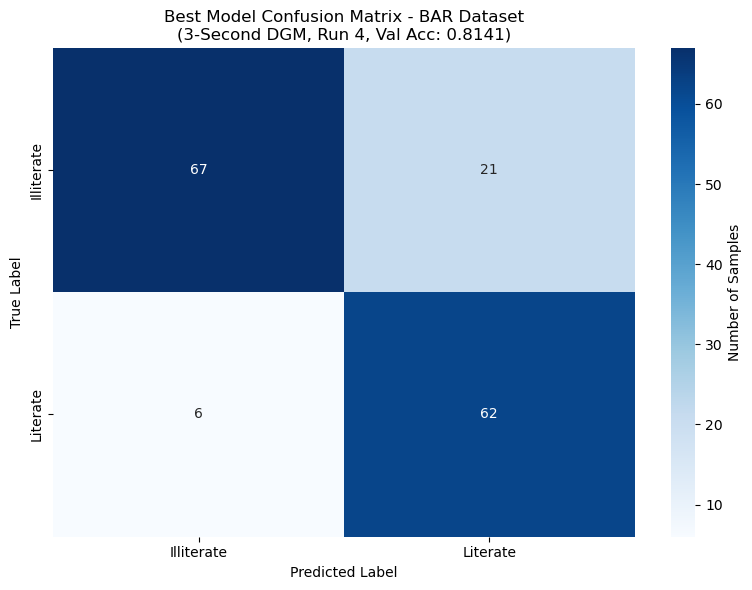

In [13]:
# RUN MULTIPLE EXPERIMENTS FOR BAR CHART DATA
print("Starting 10-run experiments for BAR chart dataset...")
print("This will take approximately 20-30 minutes depending on your hardware.")

bar_best_results, bar_all_results = run_multiple_training_experiments(
    dataset_name='bar',
    base_image_path=base_data_path,
    base_dgm_path=dgm_data_path,
    num_runs=10,
    epochs=10
)

# Display detailed results for the best bar chart model
bar_detailed_metrics = display_best_results('bar', bar_best_results)


Starting 10-run experiments for LINE chart dataset...
This will take approximately 15-25 minutes depending on your hardware.

Running 10 training experiments for LINE dataset
Using 3-second DGM time windows
Run 1/10 for line... Loaded 456 training samples for line
Loaded 114 validation samples for line
✅ Val Acc: 0.5702 (NEW BEST!)
Run 2/10 for line... Loaded 456 training samples for line
Loaded 114 validation samples for line
✅ Val Acc: 0.5614
Run 3/10 for line... Loaded 456 training samples for line
Loaded 114 validation samples for line
✅ Val Acc: 0.5702
Run 4/10 for line... Loaded 456 training samples for line
Loaded 114 validation samples for line
✅ Val Acc: 0.7281 (NEW BEST!)
Run 5/10 for line... Loaded 456 training samples for line
Loaded 114 validation samples for line
✅ Val Acc: 0.5702
Run 6/10 for line... Loaded 456 training samples for line
Loaded 114 validation samples for line
✅ Val Acc: 0.7719 (NEW BEST!)
Run 7/10 for line... Loaded 456 training samples for line
Loaded 11

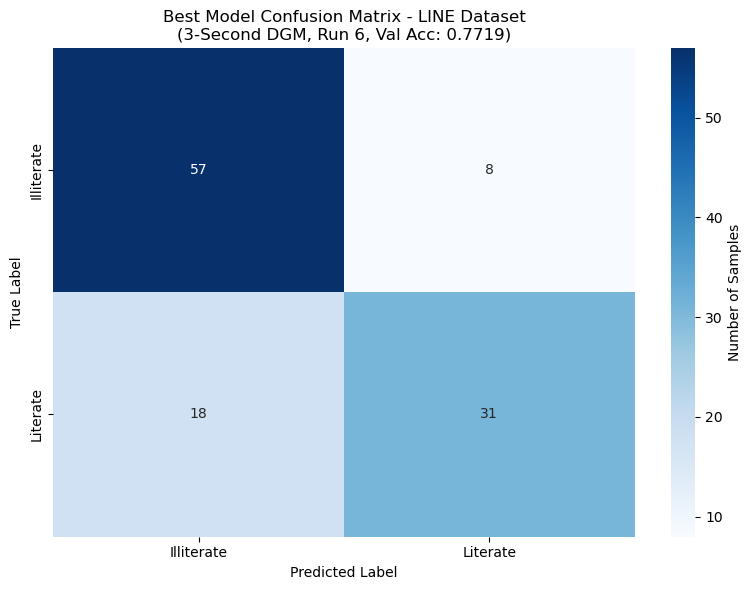

In [14]:
# RUN MULTIPLE EXPERIMENTS FOR LINE CHART DATA
print("Starting 10-run experiments for LINE chart dataset...")
print("This will take approximately 15-25 minutes depending on your hardware.")

line_best_results, line_all_results = run_multiple_training_experiments(
    dataset_name='line',
    base_image_path=base_data_path,
    base_dgm_path=dgm_data_path,
    num_runs=10,
    epochs=10
)

# Display detailed results for the best line chart model
line_detailed_metrics = display_best_results('line', line_best_results)


Starting 10-run experiments for PIE chart dataset...
This will take approximately 10-20 minutes depending on your hardware.

Running 10 training experiments for PIE dataset
Using 3-second DGM time windows
Run 1/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0.5333 (NEW BEST!)
Run 2/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0.5333
Run 3/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0.5333
Run 4/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0.5333
Run 5/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0.5333
Run 6/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0.7333 (NEW BEST!)
Run 7/10 for pie... Loaded 120 training samples for pie
Loaded 30 validation samples for pie
✅ Val Acc: 0

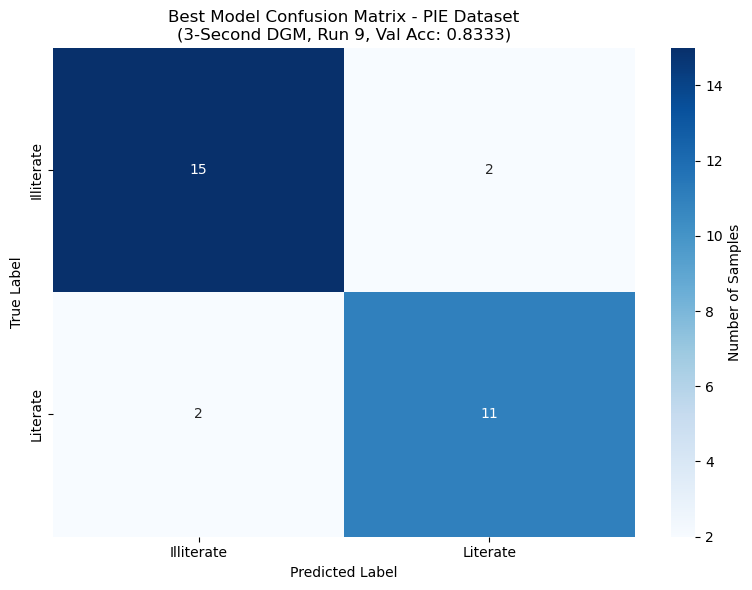

In [24]:
# RUN MULTIPLE EXPERIMENTS FOR PIE CHART DATA
print("Starting 10-run experiments for PIE chart dataset...")
print("This will take approximately 10-20 minutes depending on your hardware.")

pie_best_results, pie_all_results = run_multiple_training_experiments(
    dataset_name='pie',
    base_image_path=base_data_path,
    base_dgm_path=dgm_data_path,
    num_runs=10,
    epochs=10
)

# Display detailed results for the best pie chart model
pie_detailed_metrics = display_best_results('pie', pie_best_results)



COMPREHENSIVE RESULTS SUMMARY - VTNet with 3-Second DGM Data

📊 BEST MODEL PERFORMANCE SUMMARY:
    Dataset  Best Run  Train Accuracy  Validation Accuracy  Illiterate F1  Literate F1
 Bar Charts         4          1.0000               0.8141         0.8323       0.8212
Line Charts         6          0.9890               0.7719         0.8143       0.7045
 Pie Charts         9          0.9833               0.8333         0.8824       0.8462

🏆 OVERALL BEST PERFORMING DATASET:
Dataset: Pie Charts
Validation Accuracy: 0.8333
Training Accuracy: 0.9833
Best Run Number: 9


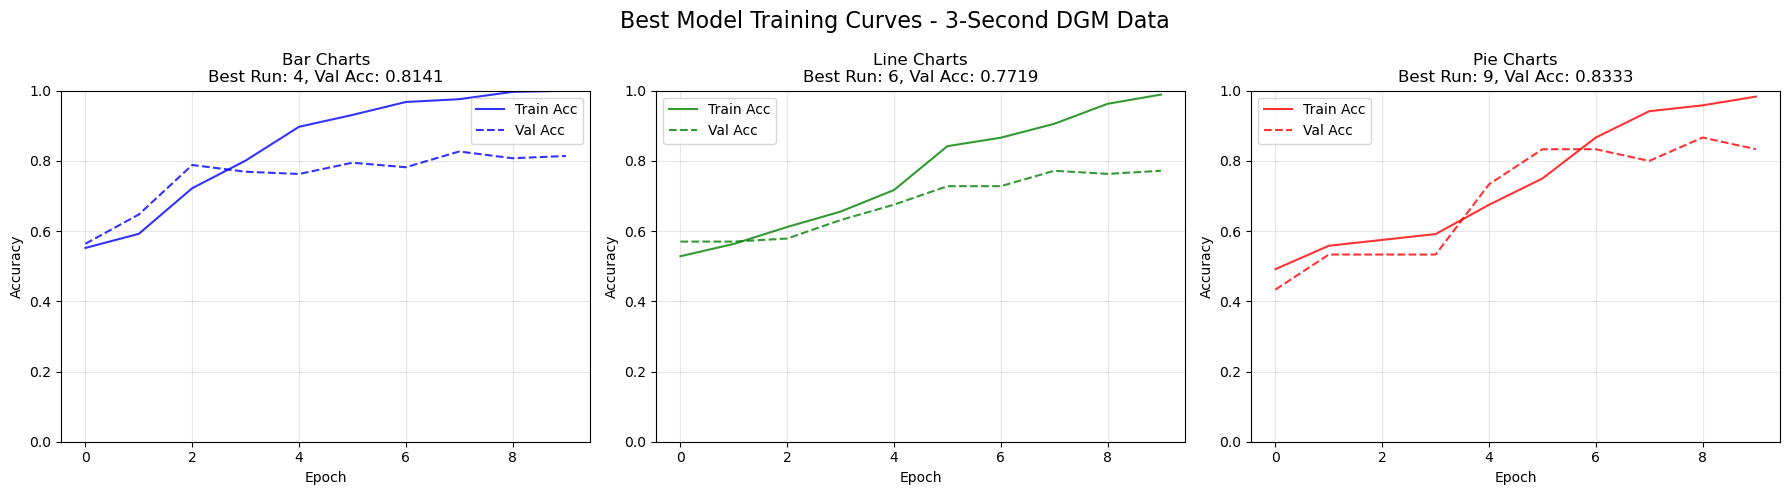


✅ All experiments completed successfully!
📁 Results are stored in variables: bar_best_results, line_best_results, pie_best_results
📊 Detailed metrics available in: bar_detailed_metrics, line_detailed_metrics, pie_detailed_metrics


In [25]:
# COMPREHENSIVE RESULTS SUMMARY
print(f"\n{'='*100}")
print(f"COMPREHENSIVE RESULTS SUMMARY - VTNet with 3-Second DGM Data")
print(f"{'='*100}")

# Create summary table
import pandas as pd

summary_data = {
    'Dataset': ['Bar Charts', 'Line Charts', 'Pie Charts'],
    'Best Run': [
        bar_best_results['run_number'],
        line_best_results['run_number'],
        pie_best_results['run_number']
    ],
    'Train Accuracy': [
        bar_best_results['final_train_acc'],
        line_best_results['final_train_acc'],
        pie_best_results['final_train_acc']
    ],
    'Validation Accuracy': [
        bar_best_results['final_val_acc'],
        line_best_results['final_val_acc'],
        pie_best_results['final_val_acc']
    ],
    'Illiterate F1': [
        bar_detailed_metrics['illiterate_f1'],
        line_detailed_metrics['illiterate_f1'],
        pie_detailed_metrics['illiterate_f1']
    ],
    'Literate F1': [
        bar_detailed_metrics['literate_f1'],
        line_detailed_metrics['literate_f1'],
        pie_detailed_metrics['literate_f1']
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n📊 BEST MODEL PERFORMANCE SUMMARY:")
print(summary_df.to_string(index=False, float_format='%.4f'))

# Find overall best performing dataset
best_dataset_idx = summary_df['Validation Accuracy'].idxmax()
best_dataset = summary_df.iloc[best_dataset_idx]

print(f"\n🏆 OVERALL BEST PERFORMING DATASET:")
print(f"Dataset: {best_dataset['Dataset']}")
print(f"Validation Accuracy: {best_dataset['Validation Accuracy']:.4f}")
print(f"Training Accuracy: {best_dataset['Train Accuracy']:.4f}")
print(f"Best Run Number: {best_dataset['Best Run']}")

# Display training curves comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = ['bar', 'line', 'pie']
dataset_names = ['Bar Charts', 'Line Charts', 'Pie Charts']
colors = ['blue', 'green', 'red']

for i, (dataset, name, color) in enumerate(zip(datasets, dataset_names, colors)):
    ax = axes[i]
    
    if dataset == 'bar':
        best_result = bar_best_results
    elif dataset == 'line':
        best_result = line_best_results
    else:
        best_result = pie_best_results
    
    history = best_result['history']
    
    # Plot training curves
    ax.plot(history['accuracy'], label='Train Acc', color=color, alpha=0.8)
    ax.plot(history['val_accuracy'], label='Val Acc', color=color, linestyle='--', alpha=0.8)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{name}\nBest Run: {best_result["run_number"]}, Val Acc: {best_result["final_val_acc"]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.0)

plt.suptitle('Best Model Training Curves - 3-Second DGM Data', fontsize=16)
plt.tight_layout()
plt.show()

print(f"\n✅ All experiments completed successfully!")
print(f"📁 Results are stored in variables: bar_best_results, line_best_results, pie_best_results")
print(f"📊 Detailed metrics available in: bar_detailed_metrics, line_detailed_metrics, pie_detailed_metrics")


# Statistical Analysis Functions

This section provides functions to:
1. Calculate statistics (mean, std, min, max) from existing experimental results
2. Run new experiments with automatic statistical reporting


In [26]:
# Function 1: Calculate statistics from existing results
def calculate_statistics_from_results(all_results, dataset_name):
    """
    Calculate comprehensive statistics from a list of training results
    
    Args:
        all_results: List of result dictionaries from multiple training runs
        dataset_name: Name of the dataset for display purposes
    
    Returns:
        stats_dict: Dictionary containing mean, std, min, max for all metrics
    """
    if not all_results or len(all_results) == 0:
        print(f"❌ No results found for {dataset_name}")
        return None
    
    # Extract metrics from all runs
    train_accs = [r['final_train_acc'] for r in all_results]
    val_accs = [r['final_val_acc'] for r in all_results]
    
    # Calculate statistics
    stats = {
        'dataset': dataset_name,
        'num_runs': len(all_results),
        'train_acc_mean': np.mean(train_accs),
        'train_acc_std': np.std(train_accs),
        'train_acc_min': np.min(train_accs),
        'train_acc_max': np.max(train_accs),
        'val_acc_mean': np.mean(val_accs),
        'val_acc_std': np.std(val_accs),
        'val_acc_min': np.min(val_accs),
        'val_acc_max': np.max(val_accs),
    }
    
    # Calculate per-class metrics from confusion matrices
    illiterate_precisions = []
    illiterate_recalls = []
    illiterate_f1s = []
    literate_precisions = []
    literate_recalls = []
    literate_f1s = []
    
    for result in all_results:
        cm = result['confusion_matrix']
        
        # Illiterate metrics
        ill_prec = cm[0,0] / (cm[0,0] + cm[1,0]) if (cm[0,0] + cm[1,0]) > 0 else 0
        ill_rec = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
        ill_f1 = 2 * (ill_prec * ill_rec) / (ill_prec + ill_rec) if (ill_prec + ill_rec) > 0 else 0
        
        # Literate metrics
        lit_prec = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
        lit_rec = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
        lit_f1 = 2 * (lit_prec * lit_rec) / (lit_prec + lit_rec) if (lit_prec + lit_rec) > 0 else 0
        
        illiterate_precisions.append(ill_prec)
        illiterate_recalls.append(ill_rec)
        illiterate_f1s.append(ill_f1)
        literate_precisions.append(lit_prec)
        literate_recalls.append(lit_rec)
        literate_f1s.append(lit_f1)
    
    # Add per-class statistics
    stats.update({
        'illiterate_precision_mean': np.mean(illiterate_precisions),
        'illiterate_precision_std': np.std(illiterate_precisions),
        'illiterate_recall_mean': np.mean(illiterate_recalls),
        'illiterate_recall_std': np.std(illiterate_recalls),
        'illiterate_f1_mean': np.mean(illiterate_f1s),
        'illiterate_f1_std': np.std(illiterate_f1s),
        'literate_precision_mean': np.mean(literate_precisions),
        'literate_precision_std': np.std(literate_precisions),
        'literate_recall_mean': np.mean(literate_recalls),
        'literate_recall_std': np.std(literate_recalls),
        'literate_f1_mean': np.mean(literate_f1s),
        'literate_f1_std': np.std(literate_f1s),
    })
    
    return stats

def print_statistics_summary(stats):
    """
    Print a formatted summary of statistics
    
    Args:
        stats: Dictionary of statistics from calculate_statistics_from_results
    """
    if stats is None:
        return
    
    print(f"\n{'='*80}")
    print(f"STATISTICAL SUMMARY - {stats['dataset'].upper()} DATASET")
    print(f"Based on {stats['num_runs']} runs")
    print(f"{'='*80}")
    
    print(f"\n📊 OVERALL ACCURACY:")
    print(f"{'Metric':<25} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
    print(f"{'-'*73}")
    print(f"{'Training Accuracy':<25} {stats['train_acc_mean']:>11.4f} {stats['train_acc_std']:>11.4f} "
          f"{stats['train_acc_min']:>11.4f} {stats['train_acc_max']:>11.4f}")
    print(f"{'Validation Accuracy':<25} {stats['val_acc_mean']:>11.4f} {stats['val_acc_std']:>11.4f} "
          f"{stats['val_acc_min']:>11.4f} {stats['val_acc_max']:>11.4f}")
    
    print(f"\n📈 ILLITERATE CLASS METRICS:")
    print(f"{'Metric':<25} {'Mean':<12} {'Std Dev':<12}")
    print(f"{'-'*49}")
    print(f"{'Precision':<25} {stats['illiterate_precision_mean']:>11.4f} {stats['illiterate_precision_std']:>11.4f}")
    print(f"{'Recall':<25} {stats['illiterate_recall_mean']:>11.4f} {stats['illiterate_recall_std']:>11.4f}")
    print(f"{'F1-Score':<25} {stats['illiterate_f1_mean']:>11.4f} {stats['illiterate_f1_std']:>11.4f}")
    
    print(f"\n📈 LITERATE CLASS METRICS:")
    print(f"{'Metric':<25} {'Mean':<12} {'Std Dev':<12}")
    print(f"{'-'*49}")
    print(f"{'Precision':<25} {stats['literate_precision_mean']:>11.4f} {stats['literate_precision_std']:>11.4f}")
    print(f"{'Recall':<25} {stats['literate_recall_mean']:>11.4f} {stats['literate_recall_std']:>11.4f}")
    print(f"{'F1-Score':<25} {stats['literate_f1_mean']:>11.4f} {stats['literate_f1_std']:>11.4f}")
    
    # Report results in paper format
    print(f"\n📝 PAPER-READY FORMAT:")
    print(f"Validation Accuracy: {stats['val_acc_mean']:.2%} ± {stats['val_acc_std']:.2%}")
    print(f"Illiterate F1-Score: {stats['illiterate_f1_mean']:.2%} ± {stats['illiterate_f1_std']:.2%}")
    print(f"Literate F1-Score: {stats['literate_f1_mean']:.2%} ± {stats['literate_f1_std']:.2%}")

print("✅ Statistics calculation functions created!")
print("\nUsage:")
print("stats = calculate_statistics_from_results(bar_all_results, 'bar')")
print("print_statistics_summary(stats)")


✅ Statistics calculation functions created!

Usage:
stats = calculate_statistics_from_results(bar_all_results, 'bar')
print_statistics_summary(stats)


In [27]:
# Test the statistics calculation on existing results
print("=" * 80)
print("ANALYZING EXISTING EXPERIMENTAL RESULTS")
print("=" * 80)

# Calculate and display statistics for BAR charts
print("\n" + "="*80)
print("BAR CHARTS - Statistical Analysis of Existing 10 Runs")
print("="*80)
bar_stats = calculate_statistics_from_results(bar_all_results, 'bar')
print_statistics_summary(bar_stats)

# Calculate and display statistics for LINE charts
print("\n" + "="*80)
print("LINE CHARTS - Statistical Analysis of Existing 10 Runs")
print("="*80)
line_stats = calculate_statistics_from_results(line_all_results, 'line')
print_statistics_summary(line_stats)

# Calculate and display statistics for PIE charts
print("\n" + "="*80)
print("PIE CHARTS - Statistical Analysis of Existing 10 Runs")
print("="*80)
pie_stats = calculate_statistics_from_results(pie_all_results, 'pie')
print_statistics_summary(pie_stats)


ANALYZING EXISTING EXPERIMENTAL RESULTS

BAR CHARTS - Statistical Analysis of Existing 10 Runs

STATISTICAL SUMMARY - BAR DATASET
Based on 10 runs

📊 OVERALL ACCURACY:
Metric                    Mean         Std Dev      Min          Max         
-------------------------------------------------------------------------
Training Accuracy              0.8596      0.1915      0.5538      1.0000
Validation Accuracy            0.7071      0.0985      0.5577      0.8141

📈 ILLITERATE CLASS METRICS:
Metric                    Mean         Std Dev     
-------------------------------------------------
Precision                      0.7622      0.1335
Recall                         0.8477      0.1060
F1-Score                       0.7847      0.0442

📈 LITERATE CLASS METRICS:
Metric                    Mean         Std Dev     
-------------------------------------------------
Precision                      0.5215      0.3422
Recall                         0.5691      0.3761
F1-Score              

In [28]:
# Function 2: New training function with automatic statistics reporting
def run_multiple_training_experiments_with_stats(dataset_name, base_image_path, base_dgm_path, 
                                                 num_runs=10, epochs=10):
    """
    Run multiple training experiments and report comprehensive statistics
    
    This function runs training multiple times and reports:
    - Mean ± standard deviation for all metrics
    - Min and max values
    - Best performing run details
    - Statistical summary suitable for research papers
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to image data
        base_dgm_path: Base path to DGM data
        num_runs: Number of training runs to perform
        epochs: Number of training epochs per run
    
    Returns:
        results_dict: Dictionary containing:
            - 'statistics': Statistical summary (mean, std, min, max)
            - 'best_results': Results from the best run
            - 'all_results': List of all run results
    """
    print(f"\n{'='*80}")
    print(f"Running {num_runs} training experiments for {dataset_name.upper()} dataset")
    print(f"Will report AVERAGE performance across all runs")
    print(f"Using 3-second DGM time windows")
    print(f"{'='*80}")
    
    all_results = []
    best_val_acc = 0
    best_results = None
    
    # Run all experiments
    for run in range(1, num_runs + 1):
        print(f"\nRun {run}/{num_runs} for {dataset_name}...")
        
        try:
            # Train the model with minimal output
            results = train_complete_vtnet_dgm(
                dataset_name=dataset_name,
                base_image_path=base_image_path,
                base_dgm_path=base_dgm_path,
                epochs=epochs,
                max_sequence_length=20,
                verbose=0  # Suppress training output
            )
            
            # Store results
            results['run_number'] = run
            all_results.append(results)
            
            # Check if this is the best run so far
            current_val_acc = results['final_val_acc']
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                best_results = results.copy()
                print(f"  ✅ Train Acc: {results['final_train_acc']:.4f}, Val Acc: {current_val_acc:.4f} (NEW BEST!)")
            else:
                print(f"  ✅ Train Acc: {results['final_train_acc']:.4f}, Val Acc: {current_val_acc:.4f}")
                
        except Exception as e:
            print(f"  ❌ Failed: {e}")
            continue
    
    # Calculate comprehensive statistics
    stats = calculate_statistics_from_results(all_results, dataset_name)
    
    # Print comprehensive summary
    print(f"\n{'='*80}")
    print(f"EXPERIMENT COMPLETE - {dataset_name.upper()} DATASET")
    print(f"{'='*80}")
    
    print_statistics_summary(stats)
    
    print(f"\n🏆 BEST PERFORMING RUN:")
    print(f"Run Number: {best_results['run_number']}")
    print(f"Validation Accuracy: {best_results['final_val_acc']:.4f}")
    print(f"Training Accuracy: {best_results['final_train_acc']:.4f}")
    
    # Create visualization of all runs
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Validation accuracy across all runs
    ax1 = axes[0]
    run_numbers = [r['run_number'] for r in all_results]
    val_accs = [r['final_val_acc'] for r in all_results]
    train_accs = [r['final_train_acc'] for r in all_results]
    
    ax1.plot(run_numbers, val_accs, 'o-', label='Validation Accuracy', linewidth=2, markersize=8)
    ax1.axhline(stats['val_acc_mean'], color='red', linestyle='--', 
                label=f'Mean: {stats["val_acc_mean"]:.4f}', linewidth=2)
    ax1.fill_between(run_numbers, 
                     stats['val_acc_mean'] - stats['val_acc_std'],
                     stats['val_acc_mean'] + stats['val_acc_std'],
                     alpha=0.2, color='red', label=f'±1 Std Dev: {stats["val_acc_std"]:.4f}')
    ax1.set_xlabel('Run Number', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title(f'{dataset_name.upper()} - Validation Accuracy Across Runs', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)
    
    # Plot 2: Box plot comparing train vs validation
    ax2 = axes[1]
    box_data = [train_accs, val_accs]
    bp = ax2.boxplot(box_data, labels=['Training', 'Validation'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightgreen')
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{dataset_name.upper()} - Accuracy Distribution', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 1.0)
    
    # Add mean markers
    means = [np.mean(train_accs), np.mean(val_accs)]
    ax2.plot([1, 2], means, 'ro', markersize=10, label='Mean', zorder=3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'statistics': stats,
        'best_results': best_results,
        'all_results': all_results
    }

print("✅ New training function with statistics created!")
print("\nUsage:")
print("results = run_multiple_training_experiments_with_stats('bar', base_data_path, dgm_data_path, num_runs=10)")
print("\nThis will:")
print("  1. Run 10 training experiments")
print("  2. Calculate mean ± std for all metrics")
print("  3. Identify and save the best run")
print("  4. Create visualizations")
print("  5. Return statistics, best results, and all results")


✅ New training function with statistics created!

Usage:
results = run_multiple_training_experiments_with_stats('bar', base_data_path, dgm_data_path, num_runs=10)

This will:
  1. Run 10 training experiments
  2. Calculate mean ± std for all metrics
  3. Identify and save the best run
  4. Create visualizations
  5. Return statistics, best results, and all results



COMPREHENSIVE COMPARISON TABLE - ALL DATASETS
VTNet with 3-Second DGM Data (Average of 10 Runs)

    Dataset Val Acc (Mean±Std)    Val Acc Range Illiterate F1   Literate F1  Num Runs
 Bar Charts      0.7071±0.0985 [0.5577, 0.8141] 0.7847±0.0442 0.5429±0.3560        10
Line Charts      0.6254±0.0872 [0.5614, 0.7719] 0.7490±0.0335 0.2207±0.3118        10
 Pie Charts      0.6167±0.1078 [0.5333, 0.8333] 0.7224±0.1305 0.4572±0.3211        10


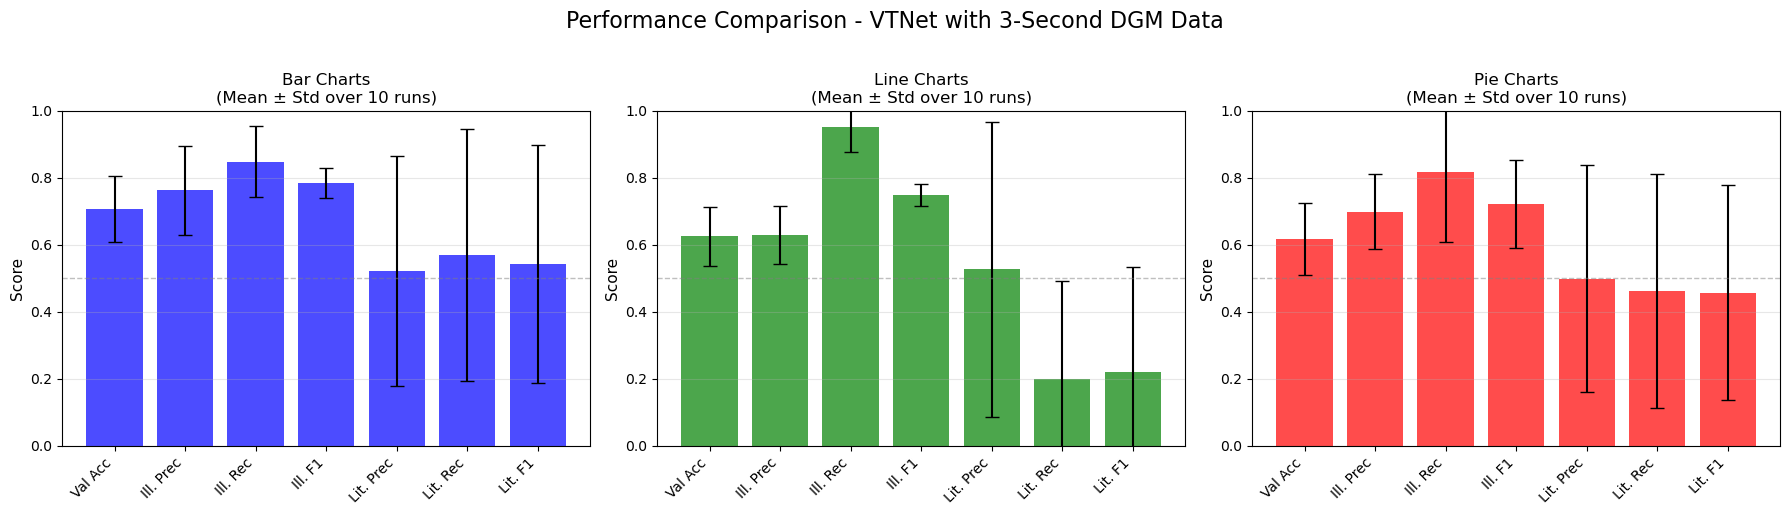


✅ Statistical analysis complete!

📊 Key Findings:
  • Bar Charts:  70.71% ± 9.85%
  • Line Charts: 62.54% ± 8.72%
  • Pie Charts:  61.67% ± 10.78%


In [29]:
# Create a comprehensive comparison table of all datasets
def create_comprehensive_comparison_table(bar_stats, line_stats, pie_stats):
    """
    Create a comprehensive comparison table suitable for research papers
    
    Args:
        bar_stats, line_stats, pie_stats: Statistics dictionaries from calculate_statistics_from_results
    
    Returns:
        DataFrame with formatted comparison
    """
    comparison_data = {
        'Dataset': ['Bar Charts', 'Line Charts', 'Pie Charts'],
        'Val Acc (Mean±Std)': [
            f"{bar_stats['val_acc_mean']:.4f}±{bar_stats['val_acc_std']:.4f}",
            f"{line_stats['val_acc_mean']:.4f}±{line_stats['val_acc_std']:.4f}",
            f"{pie_stats['val_acc_mean']:.4f}±{pie_stats['val_acc_std']:.4f}"
        ],
        'Val Acc Range': [
            f"[{bar_stats['val_acc_min']:.4f}, {bar_stats['val_acc_max']:.4f}]",
            f"[{line_stats['val_acc_min']:.4f}, {line_stats['val_acc_max']:.4f}]",
            f"[{pie_stats['val_acc_min']:.4f}, {pie_stats['val_acc_max']:.4f}]"
        ],
        'Illiterate F1': [
            f"{bar_stats['illiterate_f1_mean']:.4f}±{bar_stats['illiterate_f1_std']:.4f}",
            f"{line_stats['illiterate_f1_mean']:.4f}±{line_stats['illiterate_f1_std']:.4f}",
            f"{pie_stats['illiterate_f1_mean']:.4f}±{pie_stats['illiterate_f1_std']:.4f}"
        ],
        'Literate F1': [
            f"{bar_stats['literate_f1_mean']:.4f}±{bar_stats['literate_f1_std']:.4f}",
            f"{line_stats['literate_f1_mean']:.4f}±{line_stats['literate_f1_std']:.4f}",
            f"{pie_stats['literate_f1_mean']:.4f}±{pie_stats['literate_f1_std']:.4f}"
        ],
        'Num Runs': [
            bar_stats['num_runs'],
            line_stats['num_runs'],
            pie_stats['num_runs']
        ]
    }
    
    return pd.DataFrame(comparison_data)

# Create and display the comparison table
print("\n" + "="*100)
print("COMPREHENSIVE COMPARISON TABLE - ALL DATASETS")
print("VTNet with 3-Second DGM Data (Average of 10 Runs)")
print("="*100)

comparison_df = create_comprehensive_comparison_table(bar_stats, line_stats, pie_stats)
print("\n" + comparison_df.to_string(index=False))

# Create visualization comparing all three datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_stats = [bar_stats, line_stats, pie_stats]
dataset_names = ['Bar Charts', 'Line Charts', 'Pie Charts']
colors = ['blue', 'green', 'red']

for i, (stats, name, color) in enumerate(zip(datasets_stats, dataset_names, colors)):
    ax = axes[i]
    
    # Create bar chart with error bars
    metrics = ['Val Acc', 'Ill. Prec', 'Ill. Rec', 'Ill. F1', 'Lit. Prec', 'Lit. Rec', 'Lit. F1']
    means = [
        stats['val_acc_mean'],
        stats['illiterate_precision_mean'],
        stats['illiterate_recall_mean'],
        stats['illiterate_f1_mean'],
        stats['literate_precision_mean'],
        stats['literate_recall_mean'],
        stats['literate_f1_mean']
    ]
    stds = [
        stats['val_acc_std'],
        stats['illiterate_precision_std'],
        stats['illiterate_recall_std'],
        stats['illiterate_f1_std'],
        stats['literate_precision_std'],
        stats['literate_recall_std'],
        stats['literate_f1_std']
    ]
    
    x_pos = np.arange(len(metrics))
    ax.bar(x_pos, means, yerr=stds, alpha=0.7, color=color, capsize=5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{name}\n(Mean ± Std over {stats["num_runs"]} runs)', fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.suptitle('Performance Comparison - VTNet with 3-Second DGM Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ Statistical analysis complete!")
print("\n📊 Key Findings:")
print(f"  • Bar Charts:  {bar_stats['val_acc_mean']:.2%} ± {bar_stats['val_acc_std']:.2%}")
print(f"  • Line Charts: {line_stats['val_acc_mean']:.2%} ± {line_stats['val_acc_std']:.2%}")
print(f"  • Pie Charts:  {pie_stats['val_acc_mean']:.2%} ± {pie_stats['val_acc_std']:.2%}")


# Example: Using the New Training Function (Optional)

**Note:** You already have results from 10 runs. Only run this if you want to:
- Verify the statistical approach with fresh experiments
- Test with different hyperparameters
- Generate new visualizations with the enhanced reporting

Uncomment the code below to run a new experiment with automatic statistical reporting.


In [ ]:
# OPTIONAL: Run new experiments with automatic statistics reporting
# Uncomment the code below to run a fresh experiment

# Example for a single dataset:
# bar_results_new = run_multiple_training_experiments_with_stats(
#     dataset_name='bar',
#     base_image_path=base_data_path,
#     base_dgm_path=dgm_data_path,
#     num_runs=10,
#     epochs=10
# )
# 
# # Access the results:
# bar_stats_new = bar_results_new['statistics']
# bar_best_new = bar_results_new['best_results']
# bar_all_new = bar_results_new['all_results']

# Example for all three datasets:
# all_new_results = {}
# for dataset in ['bar', 'line', 'pie']:
#     print(f"\n\n{'='*100}")
#     print(f"STARTING NEW EXPERIMENTS FOR {dataset.upper()} DATASET")
#     print(f"{'='*100}\n")
#     
#     all_new_results[dataset] = run_multiple_training_experiments_with_stats(
#         dataset_name=dataset,
#         base_image_path=base_data_path,
#         base_dgm_path=dgm_data_path,
#         num_runs=10,
#         epochs=10
#     )

print("💡 Tip: You already have statistical analysis from your existing 10 runs!")
print("📊 Results are available in variables: bar_stats, line_stats, pie_stats")
print("\n🔬 To run NEW experiments with enhanced reporting, uncomment the code above.")
